In [116]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import weather_temp_alphas, weather_costs, model_01, validate, prediction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask]
    test_mask = (data.index > "2011")
    test = data[test_mask]
    return train, test

In [3]:
all_weather = pd.read_csv("weather01-16.csv")

In [4]:
cm_weather = all_weather[all_weather.stn_name == "Chiang Mai"]
cm_weather.index = pd.DatetimeIndex(cm_weather.date)
mask = (cm_weather.index > "2003") & (cm_weather.index < "2016")
cm_weather = cm_weather[mask]

provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)
cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])

In [5]:
cm_avg_weather = cm_weather[['avgrh','dday','meantemp']].resample('W').mean()
cm_avg_weather['rain'] = cm_weather[['rain']].resample('W').sum() # cumulative rainfall
cm_dengues_weather = pd.concat([cm_avg_weather,cm_dengues_df[:-52]],axis=1)

cm_dengues_weather_split = split_data(cm_dengues_weather)
cm_dengues_train, cm_dengues_test = cm_dengues_weather_split[0], cm_dengues_weather_split[1]

In [94]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "%s's Dengue Prediction with Mean Temperature"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(cm_dengues_df.cases,cm_dengues_train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
    plt.savefig("16-lags-16-weeks-9-temp-wks-chiangmai-00.png")
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)
    
def show_predictions(params, real, province, ws):
    LAG, TEMPERATURE_WEEKS, RAIN_WEEKS = params[0], params[1], params[2]
    
    predictions_to_plot = prediction.get_predictions(
        LAG, 
        TEMPERATURE_WEEKS,
        RAIN_WEEKS,
        real,
        ws,
        province)
    
    plot_all_predictions(LAG, 
                         real.cases,
                         province,
                         [1,2,4,8,16],
                         predictions_to_plot)
    
    

In [117]:
import multiprocessing as mp
from multiprocessing import Process, Queue

# Define an output queue
output = Queue()

# def validate

# def compute_ret(temp):
#     for i in range(int(1e5)): pass
#     return temp/2.


ws_csv = np.array(pd.read_csv("best-with-19-lags-14-temps-ws-1st-iter-model-a.csv").T)[0]
    
def validation(LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, train, real, output):
                                    # get_alphas takes 4 args, if theres no input csv
    alphas = weather_alphas.get_alphas(LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, train, ws_csv)
                                    # get_predictions takes 6 args
    predictions_to_validate = prediction.get_predictions(LAG, TEMPERATURE_WEEKS, RAIN_WEEKS, real, alphas.x, "CM")
                                    # get_validations takes 3 argsg
    validated_result = validate.get_validations(LAG, predictions_to_validate, real)
    output.put((TEMPERATURE_WEEKS,validated_result,alphas.x)) # add in ws as well alphas.x


In [118]:
%%time
# Setup a list of processes that we want to run
train = cm_dengues_train
real = cm_dengues_weather
processes = [Process(target=validation, args=(19, weeks, 10, train, real, output)) for weeks in range(10,15)]
print ws_csv

# Run processes
for p in processes:
    p.start()

# Exit the completed processes
for p in processes:
    p.join()

# Get process results from the output queue
results = [output.get() for p in processes]

print(results)

[  3.75164554e-01   2.57944040e-08   8.06437884e-08   9.09234382e-08
   1.28813677e-07   1.02091877e-07   9.74234389e-08   4.20666868e-08
   4.56024522e-08   4.67506499e-08   9.58222066e-09   3.18285865e-09
   7.71514721e-09   1.15469230e-08   1.25299884e-01   4.98965054e-03
   3.01063264e-03   3.51274466e-05   2.88835619e-06   4.66305326e-01
   1.67950662e+00   7.77502916e+00   1.62668116e-01   5.89580445e-02
  -9.17072254e-03  -2.69270905e-02  -2.83934709e-02  -1.53448717e-02
  -7.76256011e-03  -6.19917329e-03   6.92190286e-03  -1.98003362e-02
  -3.41522099e-03   7.44573688e-03  -9.62878054e-04   1.01514670e-02
   3.18145790e-02   5.17262161e-02   3.18203639e-02   1.63154845e-02
   1.03294363e-02   5.99225062e-03   3.49632525e-03  -4.11705577e-04
  -8.22957365e-04  -1.40876044e-04   1.22571418e-04   5.06958474e-04]
44
LAG 19
bnds 19 44
ws_csv
prev_ws 33
all_prev_ws 44
45
46
LAG 19
bnds 19 46
LAG 19
ws_csv
prev_ws 35
bnds 19 45
all_prev_ws 46
ws_csv
47
prev_ws 34
LAG 19
bnds 19 47
all

Process Process-111:
Traceback (most recent call last):
Process Process-114:
Process Process-112:
Process Process-113:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
Process Process-115:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self.r

  File "/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py", line 2474, in get_value
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/series.py", line 254, in __init__
KeyboardInterrupt
    self.name = name
    k = self._convert_scalar_indexer(k, kind='getitem')
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py", line 3103, in __setattr__
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/datetimelike.py", line 621, in _convert_scalar_indexer
    ._convert_scalar_indexer(key, kind=kind))
    object.__setattr__(self, '_name', value)
    object.__setattr__(self, name, value)
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/numeric.py", line 142, in _convert_scalar_indexer
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/series.py", line 328, in name
    ._convert_scalar_indexer(key, kind=kind))
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py", line 1310, in _convert_scalar

KeyboardInterrupt: 

In [110]:
def get_best(validations):
    idx = None
    best_so_far = validations[0][1][-1]
    print best_so_far
    for i in range(len(validations)):
        cur_validation = validations[i][1]
#         print cur_validation
        if cur_validation[0] <= best_so_far:
            best_so_far = cur_validation[0]
            idx = i
    return validations[idx]
        
    
best_param = get_best(results)

1839.79709882


In [111]:
best_param

(14,
 [164.50631781941073,
  281.9284334157669,
  530.21142874399311,
  948.11669946140239,
  1554.4164569285895],
 array([  3.75164554e-01,   2.57944040e-08,   8.06437884e-08,
          9.09234382e-08,   1.28813677e-07,   1.02091877e-07,
          9.74234389e-08,   4.20666868e-08,   4.56024522e-08,
          4.67506499e-08,   9.58222066e-09,   3.18285865e-09,
          7.71514721e-09,   1.15469230e-08,   1.25299884e-01,
          4.98965054e-03,   3.01063264e-03,   3.51274466e-05,
          2.88835619e-06,   4.66305326e-01,   1.67950662e+00,
          7.77502916e+00,   1.62668116e-01,   5.89580445e-02,
         -9.17072254e-03,  -2.69270905e-02,  -2.83934709e-02,
         -1.53448717e-02,  -7.76256011e-03,  -6.19917329e-03,
          6.92190286e-03,  -1.98003362e-02,  -3.41522099e-03,
          7.44573688e-03,  -9.62878054e-04,   1.01514670e-02,
          3.18145790e-02,   5.17262161e-02,   3.18203639e-02,
          1.63154845e-02,   1.03294363e-02,   5.99225062e-03,
          3.49632

In [113]:
# pd.DataFrame(best_param[2]).to_csv("best-with-19-lags-14-temps-ws-1st-iter.csv",index=False)
# np.array(pd.read_csv("best-with-19-lags-14-temps-ws-1st-iter.csv").T)[0]

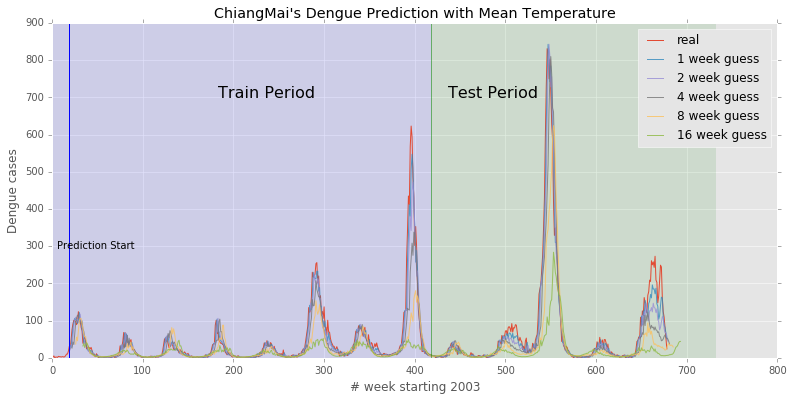

In [114]:
ws = np.array(pd.read_csv("best-with-19-lags-14-temps-ws-1st-iter-model-a.csv").T)[0]
real = cm_dengues_weather
show_predictions([19,14,10], real, "ChiangMai", ws)

In [58]:
# pd.DataFrame(best_param[2]).to_csv("best-with-19-lags-10-temps-ws-1st-iter.csv",index=False)
# np.array(pd.read_csv("best-for-19-lags-ws-3rd-iter.csv").T)[0]

getting bounded alphas ...
done getting alphas ...


In [32]:
chosen_ws = glob.glob("best-*.csv")
for ws_set_file in chosen_ws:
    ws_set = np.array(pd.read_csv(ws_set_file).T)[0]
#     print ws_set_file
    LAG = int(ws_set_file[9:11])
    to_validate = prediction.get_predictions(LAG, 9, 10, real, ws_set)
    print "LAG %d"%LAG,validate.get_validations(LAG, to_validate, real)

LAG 23 [205.82624824351581, 374.86547851071168, 726.02637891644849, 1284.8735497820055, 1627.4597425170004]
LAG 21 [166.85156662968512, 292.0898130079363, 564.366573591867, 1035.0747400189584, 1527.0827702830245]
LAG 22 [168.91992707974032, 294.43310789395724, 581.26512237641293, 1094.9170235354613, 1583.9765963384611]
LAG 19 [166.58144315243547, 288.90438923758734, 543.77910579020795, 947.7903870066549, 1391.3705312824545]


In [147]:
# # pd.DataFrame(best_param[2]).to_csv("best-for-18-lags-ws.csv",index=False)

# lg = [16,17,18,20,22]
# a = np.array(pd.read_csv("best-for-18-lags-ws.csv").T)[0]

# # for i in lg:
# #     if i == len(a):
# #         arr = a
# #         print len(arr)
# #     elif i < len(a):
# #         arr = a[:-(18-i)]
# #         print len(arr)
# #     else:
# #         mean_val = 1/float(i)
# #         arr = np.append(a,[mean_val]*(i-len(a)))
# #         print arr
        
# def ws_helper(LAG, ws, 18):
#     n_ws = len(ws)
#     if LAG == n_ws:
#         print "eq"
#         arr = ws[:LAG+1]
#     elif LAG < n_ws:
#         print "les"
#         arr = ws[:-(n_ws - LAG + 1)]
#     else:
#         print "else"
#         tail = (LAG - n_ws) - 1
#         mean_val = 1/(float(LAG)*tail)
#         arr = np.append(ws,[mean_val]*tail)
#     return arr

# len(ws_helper(20,a))

les


19